In [18]:
import math
import numpy as np
import networkx as nx
from Graph import Graph
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import InterpolatedWaveform, BlackmanWaveform, RampWaveform
from pulser_simulation import QutipBackend

### Step 1
Model the problem of antenna frequency assignment as a graph coloring problem on unit-disk graphs (see
16/10 lecture)

```
antenna 1 (0, 0)
antenna 2 (3, 5.2)
antenna 3 (6, 0)
antenna 4 (9, -5.2)
antenna 5 (9, 0)
antenna 6 (9, 5.2)
antenna 7 (9, 10.4)
antenna 8 (12, 0)
```

In [4]:
antenna_coordinates = [(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)]

In [5]:
def build_graph_from_antenna_coordinates(antenna_coordinates, problem_size=8, interference_treshold=8.7):
    G = Graph(antenna_coordinates)
    return G

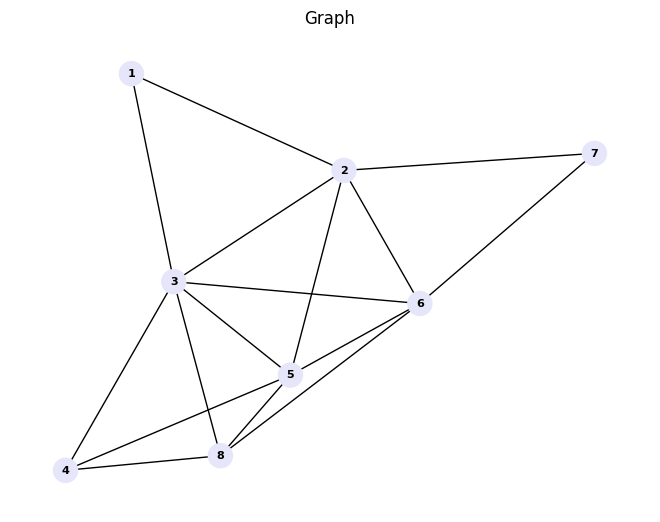

In [6]:
G = build_graph_from_antenna_coordinates(antenna_coordinates)
pos = nx.spring_layout(G.graph)
G.show_graph(pos)

### Step 2
Design an algorithm to solve graph coloring by using repeated applications of maximum independent set
(MIS) (see 16/10 lecture)

In [7]:
def compute_cost(G, independant_set):
    """
        MIS cost function.
        ---------
        - G : graph
        - independant_set : bitstring candidate for cost computation
    """
    N = len(G)
    adj = nx.to_numpy_array(G)
    cost = 0
    cost -= sum(independant_set)
    for i in range(N):
        for j in range(N):
            if adj[i][j] == 1 and independant_set[i] == independant_set[j] == 1:
                cost += 1
    return cost

In [8]:
def solve_MIS(G: nx.Graph) -> tuple[str, int]:
    """
        Returns the MIS bitstring along with its cost.
        ----------
        - G : graph
    """
    N = G.number_of_nodes()
    bitstrings = [np.binary_repr(i, N) for i in range(2 ** N)]
    costs = []
    min_cost = compute_cost(G, [int(bit) for bit in bitstrings[0]])
    for b in bitstrings:
        x = [int(bit) for bit in b]
        cost = compute_cost(G, x)
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost

    results = zip(bitstrings, costs)
    results = sorted(results, key=lambda x: x[1])
    return results[0], min_cost

In [9]:
def visualize_graph_with_colors(G, colors):
    """
        Method for visualizing graph with colored nodes.
        ---------
        - G : graph
        - colors : list of colors
        - label : labels for each nodes
    """
    pos = nx.spring_layout(G, seed=42)  # Layout for consistent node positions
    nx.draw_networkx(G, pos, with_labels=True, node_color=colors)

In [10]:
import matplotlib.pyplot as plt

def graph_coloring(G):
    pos = nx.spring_layout(G.graph)
    new_graph = G.graph.copy()
    initial_bitstr = ["0"] * G.graph.number_of_nodes()
    all_graphs = [new_graph]
    while new_graph.number_of_nodes() > 0:
        nodes = new_graph.nodes()
        (bitstr, _), _ = solve_MIS(new_graph)
        for i, node in enumerate(nodes):
            if bitstr[i] == '1':
                initial_bitstr[node - 1] = '1'
        initial_bitstr = ''.join(initial_bitstr)
        new_graph = G.def_colors(initial_bitstr)
        G.show_graph(pos)

        all_graphs.append(new_graph)
        initial_bitstr = ["0"] * G.graph.number_of_nodes()
    return all_graphs
    

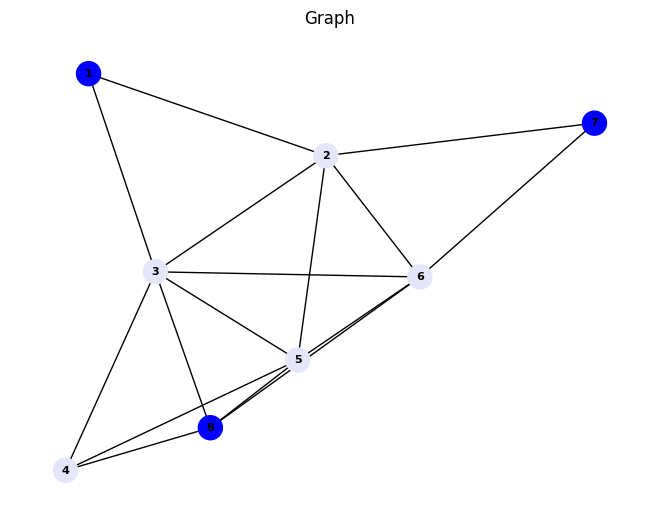

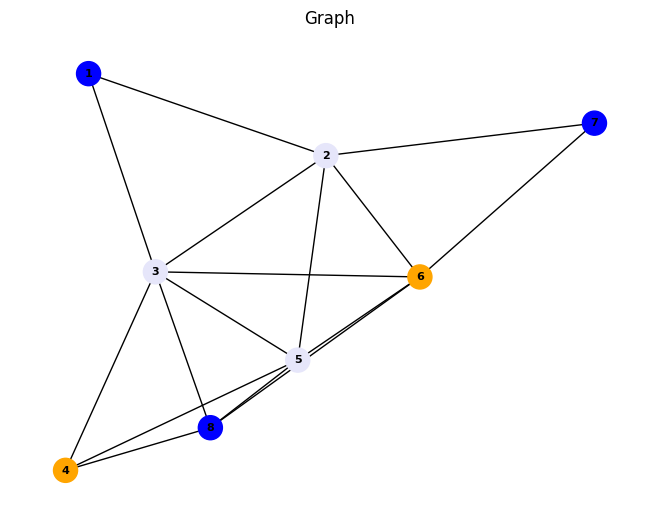

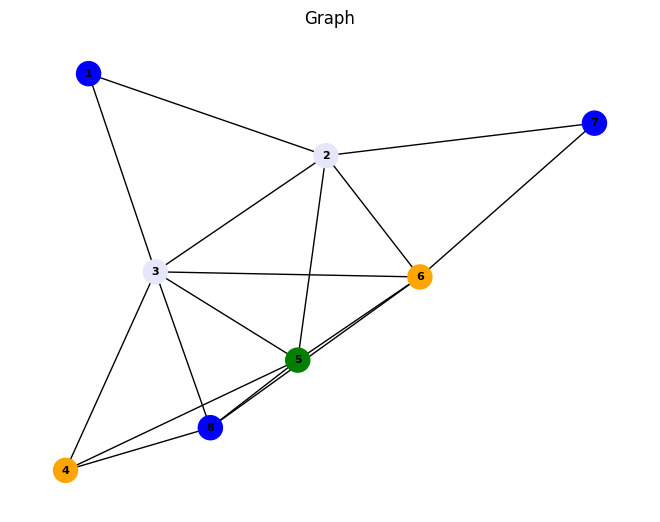

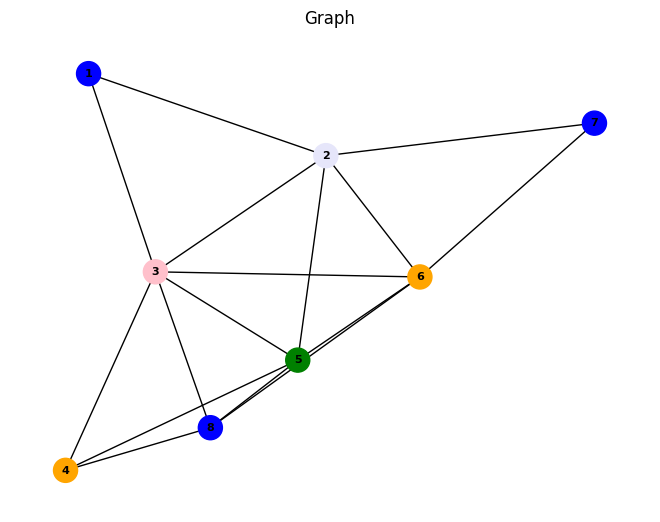

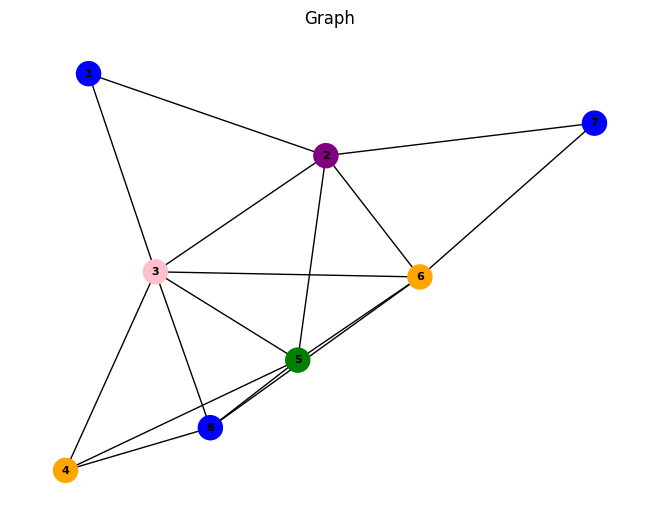

In [11]:
coloring_steps = graph_coloring(G)

### Step 3
Implement a MIS solver in Pulser (see 23/10 lecture)

In [19]:
def neutral_atom_MIS_solver(antenna_coordinates, interference_treshold=8.7):
    qubit_positions = {f'q{i+1}' : antenna_coordinates[i] for i in range(len(antenna_coordinates)) if antenna_coordinates[i] is not None}
    reg = Register(qubit_positions)
    reg.draw(blockade_radius=interference_treshold)
    omega = MockDevice.rabi_from_blockade(interference_treshold)
    seq = Sequence(reg, MockDevice)
    seq.declare_channel('ch', 'rydberg_global')
    """
    omega_wf = InterpolatedWaveform(10000, [0, omega, 0])
    delta_wf = InterpolatedWaveform(10000, [-20, 0, 20])
    """
    omega_wf = BlackmanWaveform(1000, np.pi)
    delta_wf = RampWaveform(1000, -5, 10)
    pulse = Pulse(omega_wf, delta_wf, 0)
    seq.add(pulse, 'ch')
    
    
    sim = QutipBackend(seq)
    results = sim.run()
    samples = results.sample_final_state(1000)
    higher_proba_state = max(samples, key=samples.get)
    return higher_proba_state

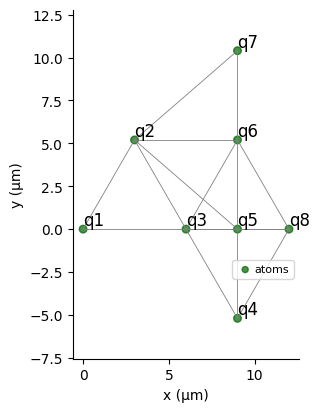

MIS = 10000010


In [20]:
antenna_coordinates = [(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)]
pulser_MIS_result = neutral_atom_MIS_solver(antenna_coordinates)
print(f"MIS = {pulser_MIS_result}")

### Step 4
Implement your graph coloring algorithm in Pulser using the MIS solver of step 3

In [21]:
def neutral_atom_graph_coloring(antenna_coordinates):
    G = Graph(antenna_coordinates)
    pos = nx.spring_layout(G.graph)
    new_graph = G.graph.copy()
    initial_bitstr = ["0"] * G.graph.number_of_nodes()
    all_graphs = [new_graph]
    while new_graph.number_of_nodes() > 0:
        nodes = new_graph.nodes()
        bitstr = neutral_atom_MIS_solver(antenna_coordinates)
        for i, node in enumerate(nodes):
            if bitstr[i] == '1':
                initial_bitstr[node - 1] = '1'
                antenna_coordinates[node - 1] = None
        initial_bitstr = ''.join(initial_bitstr)
        new_graph = G.def_colors(initial_bitstr)
        G.show_graph(pos)

        all_graphs.append(new_graph)
        initial_bitstr = ["0"] * G.graph.number_of_nodes()

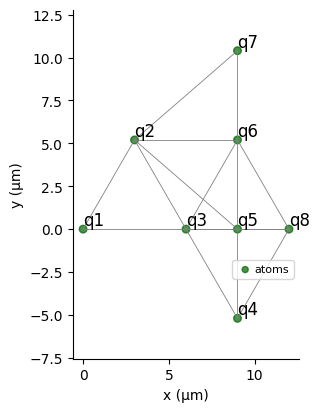

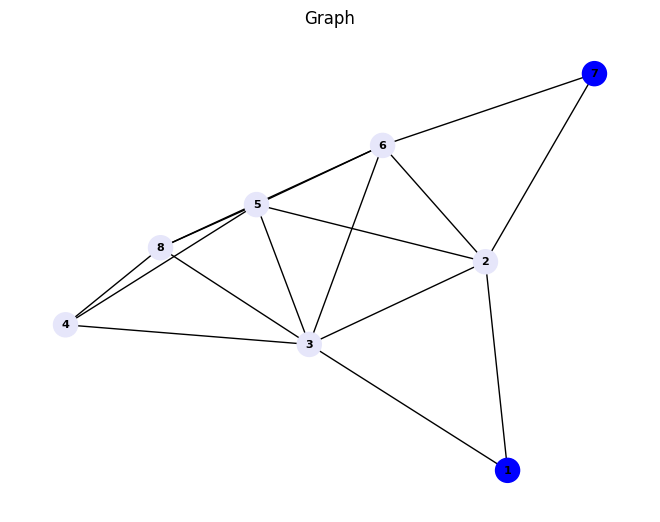

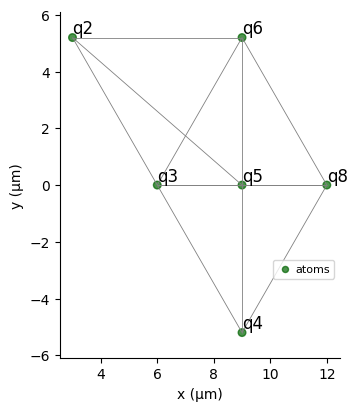

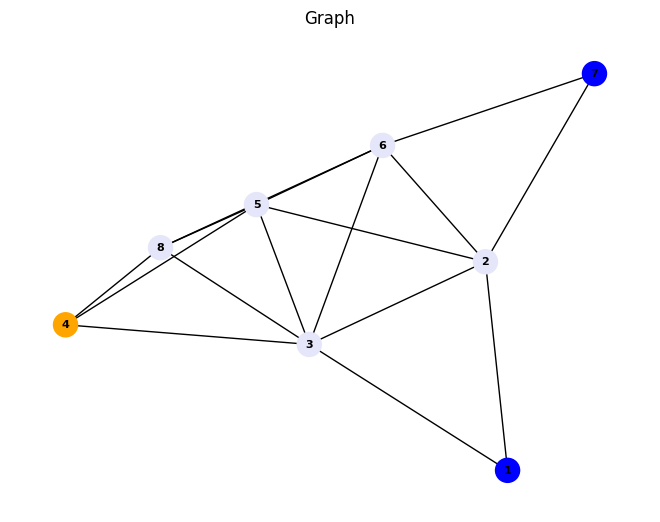

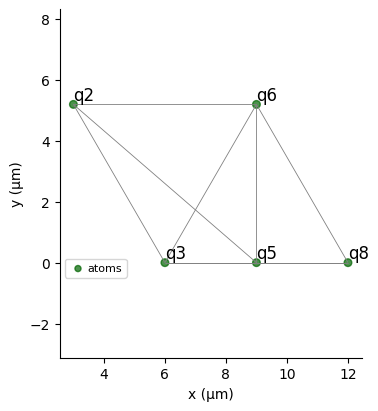

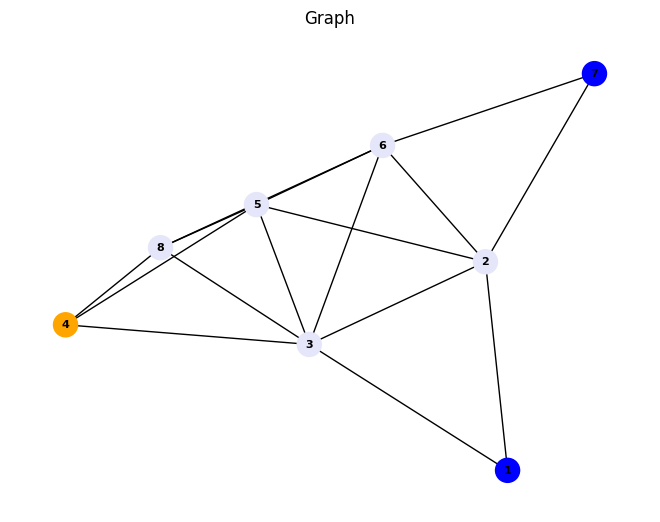

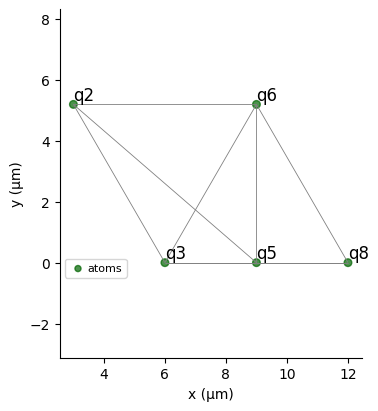

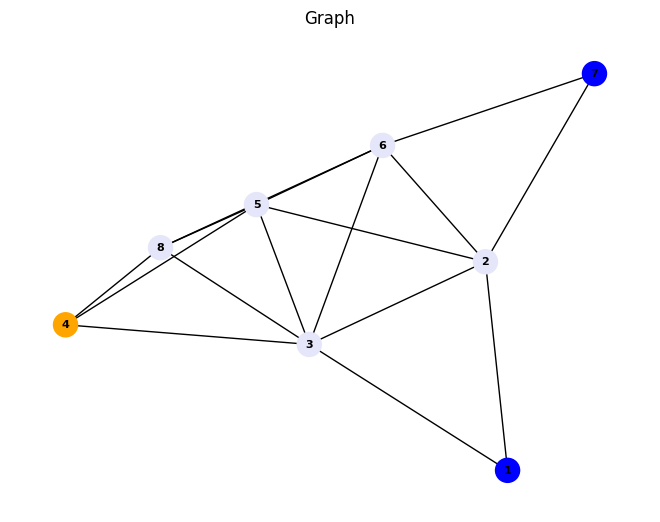

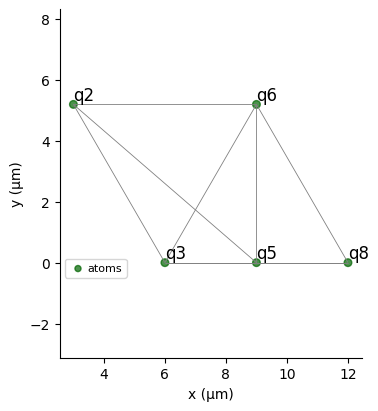

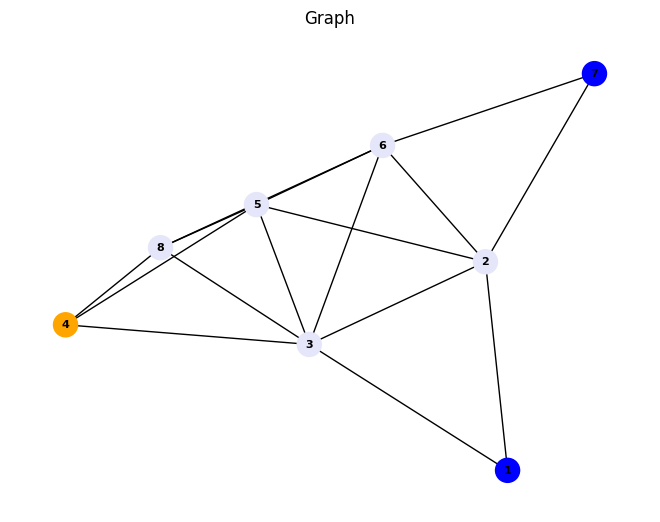

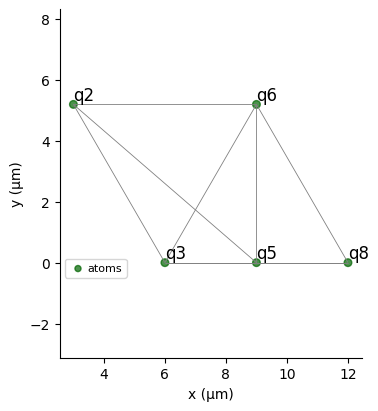

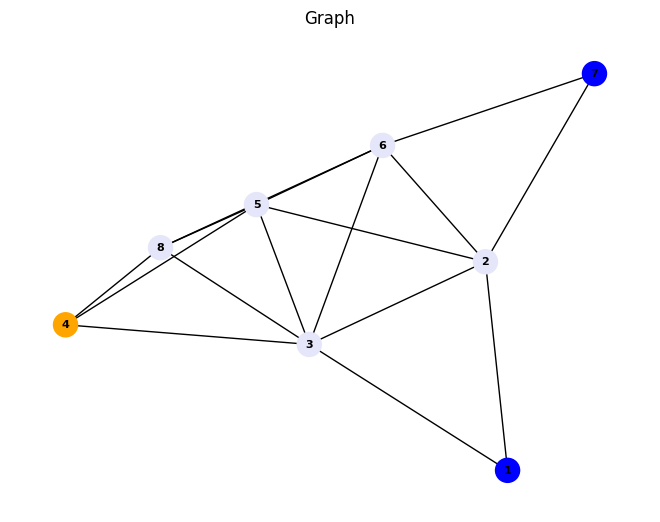

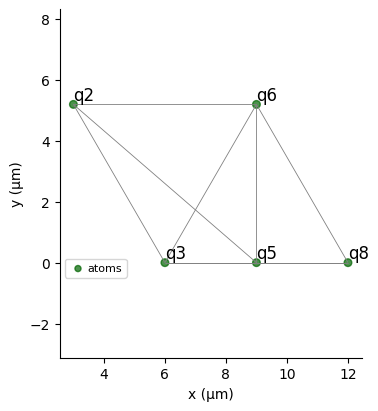

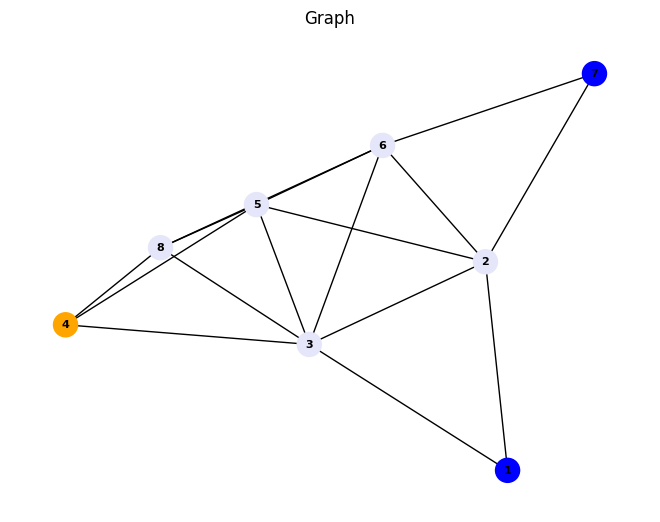

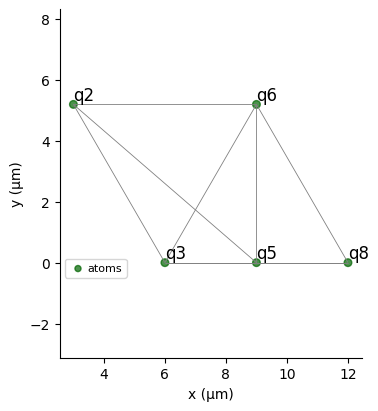

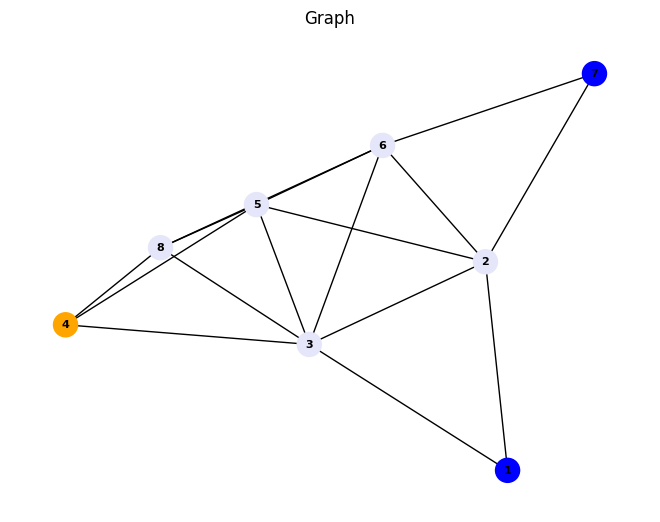

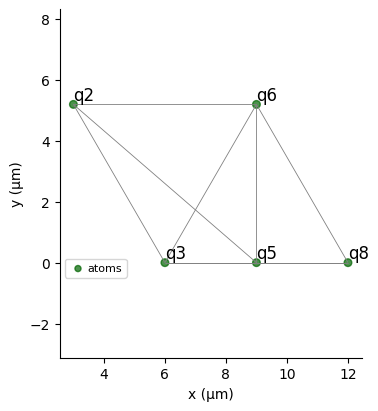

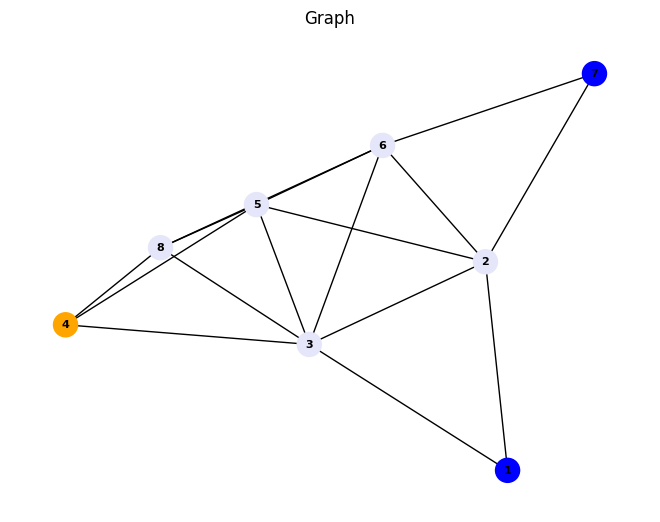

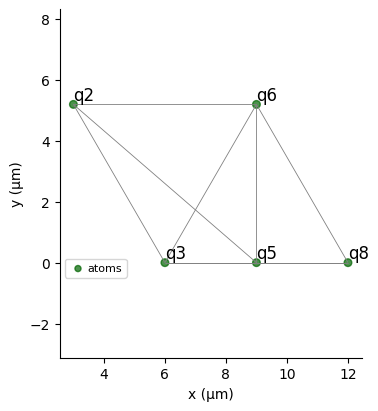

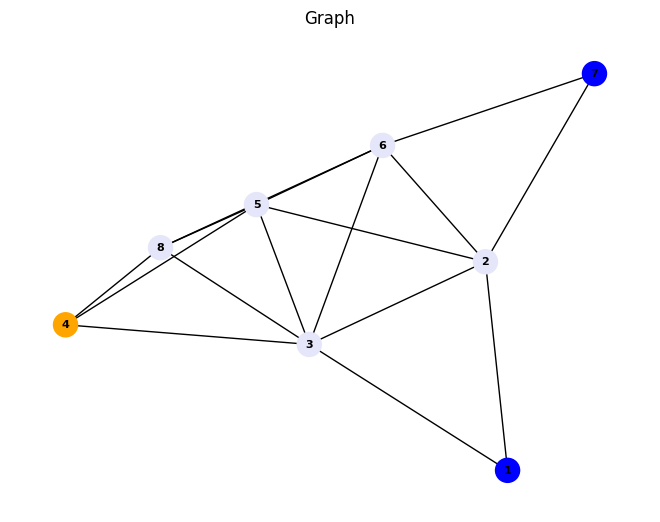

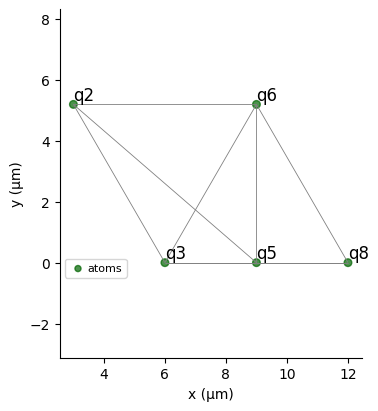

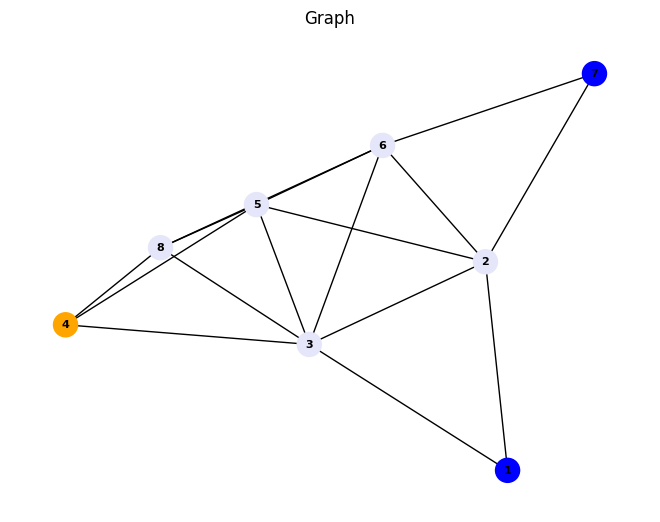

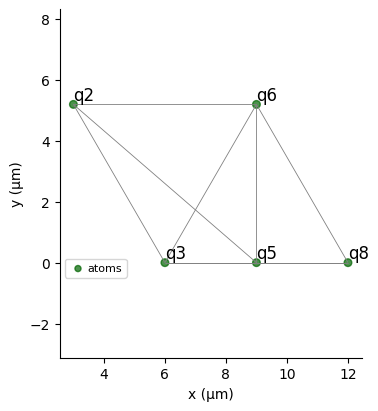

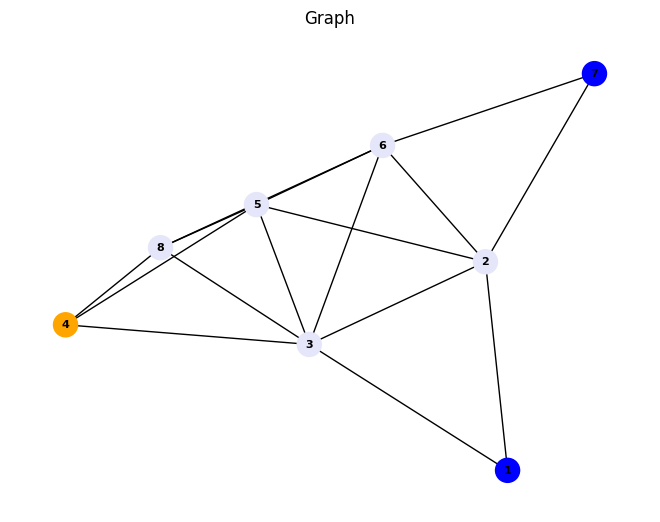

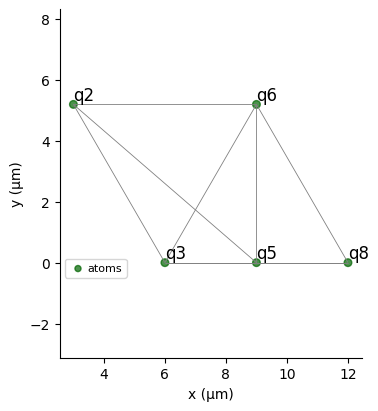

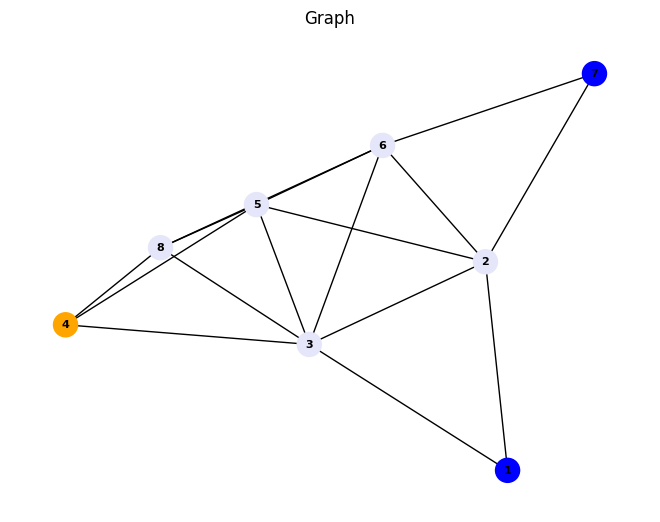

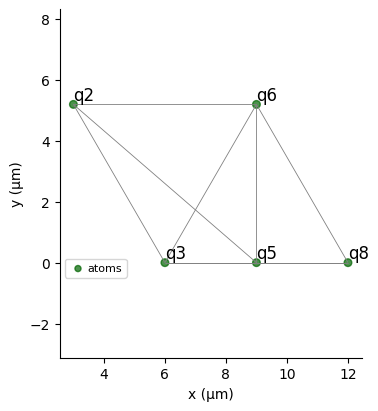

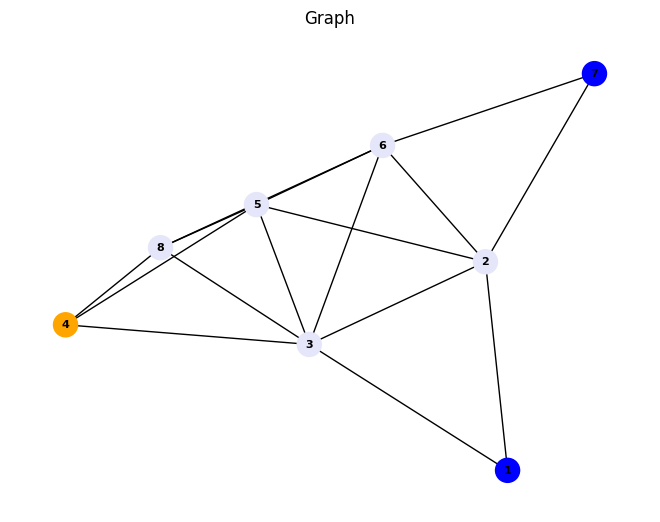

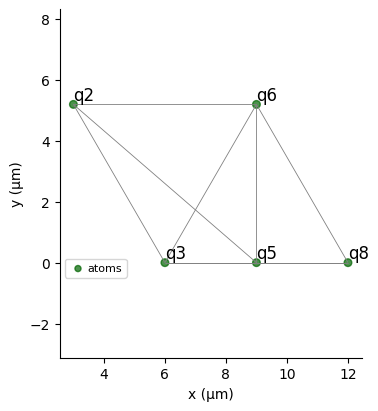

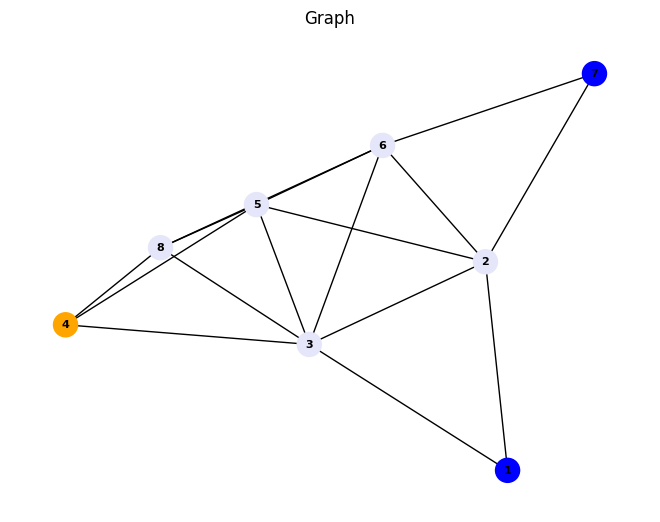

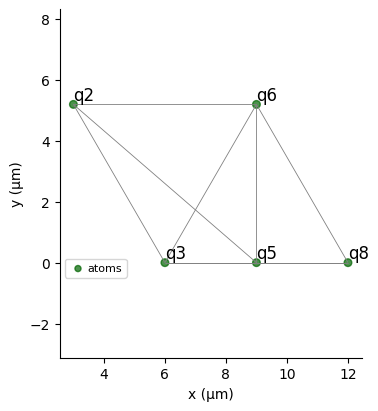

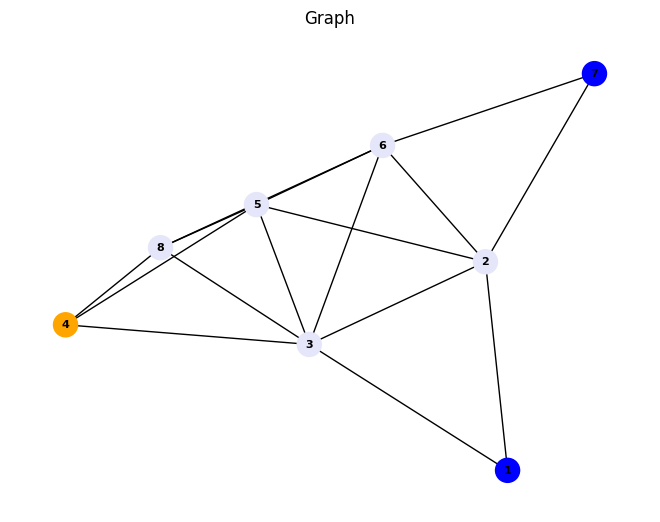

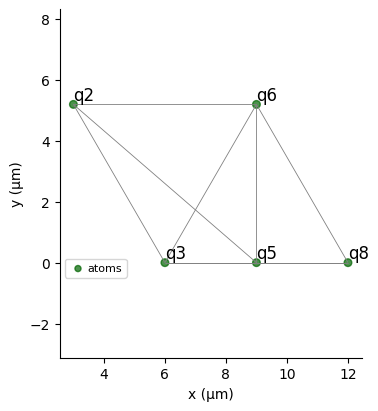

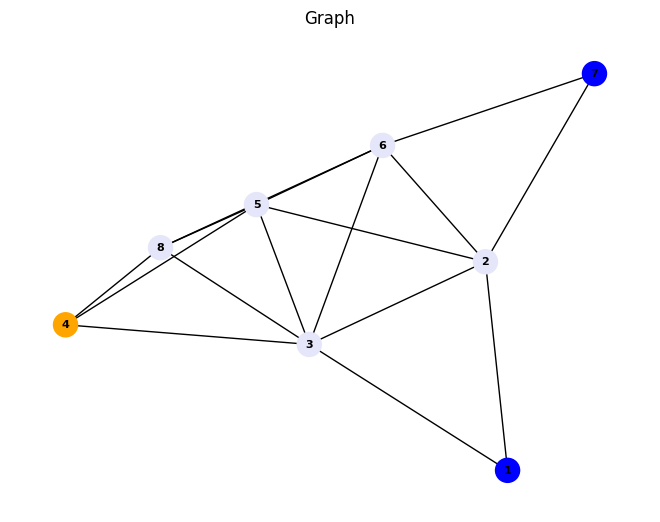

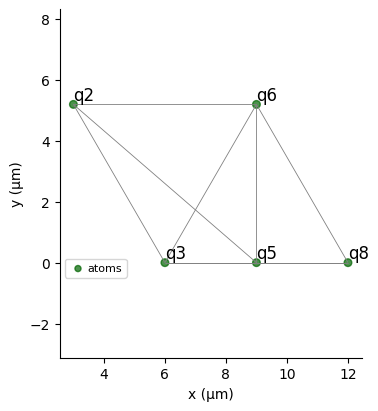

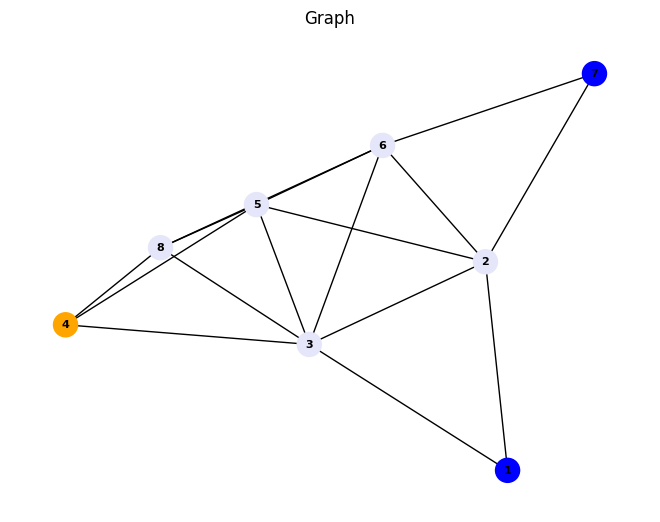

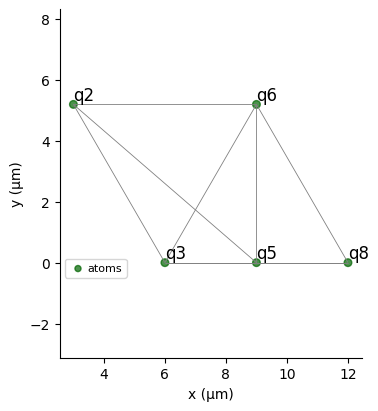

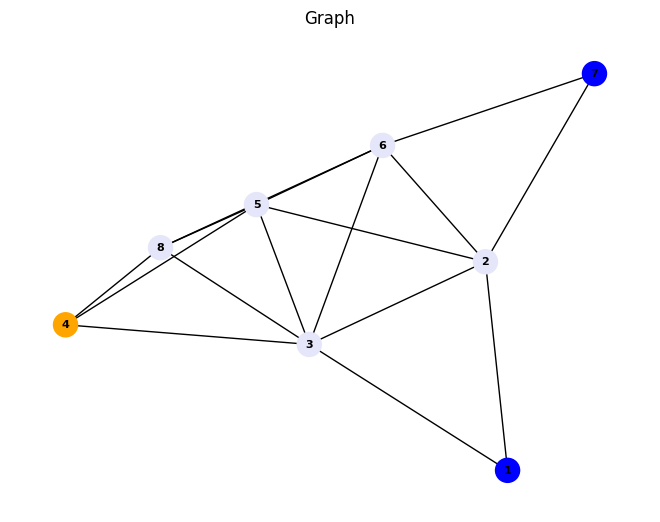

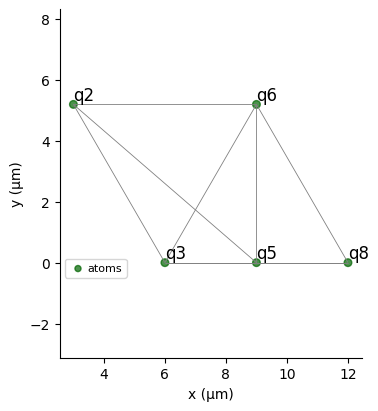

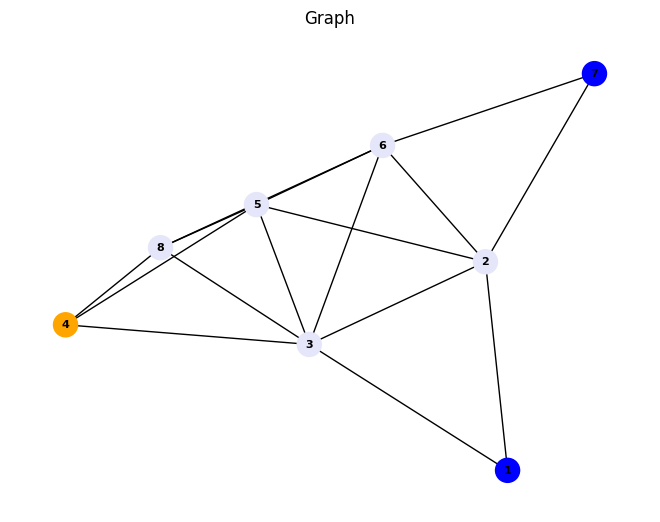

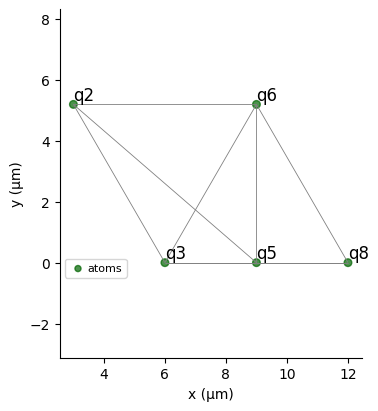

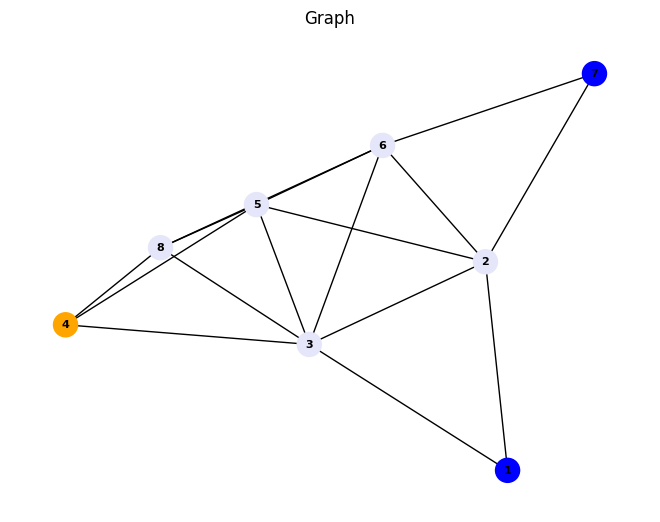

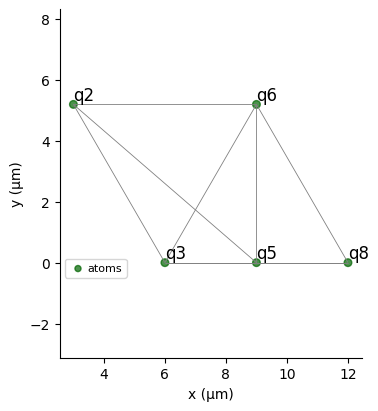

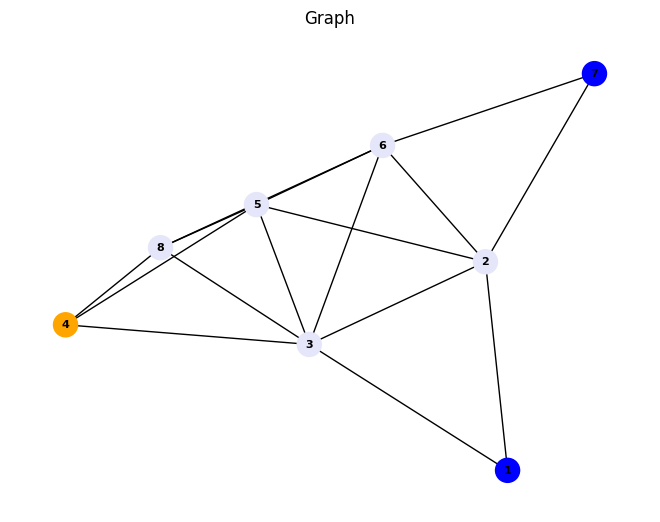

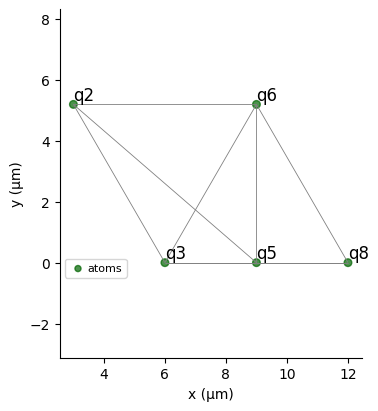

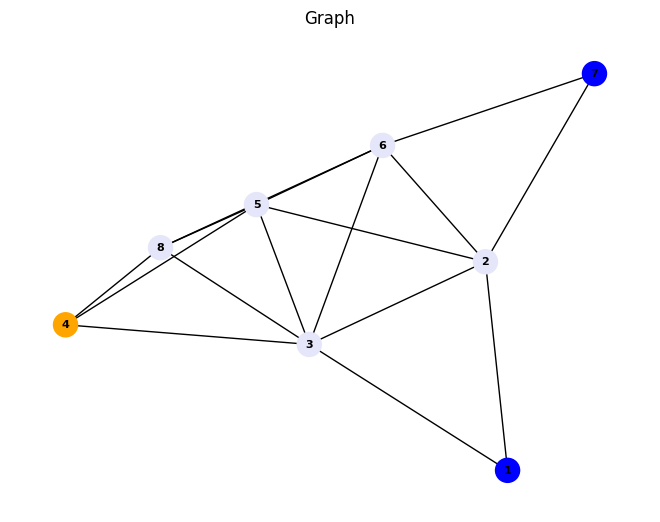

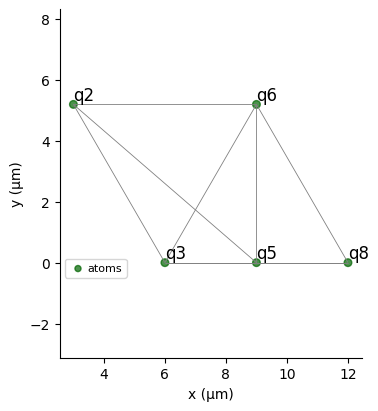

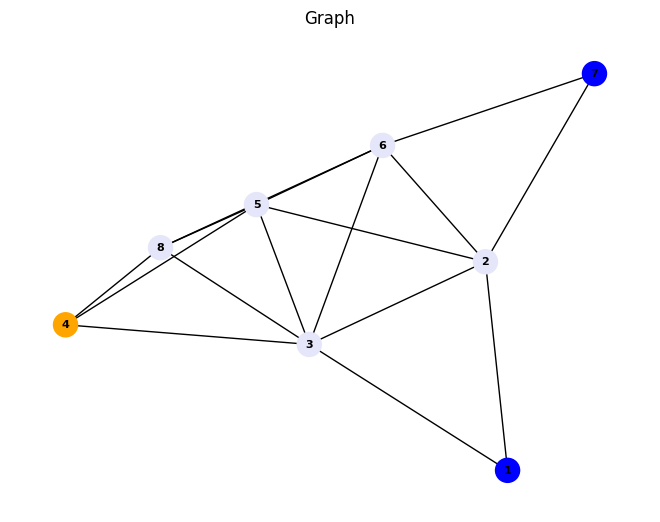

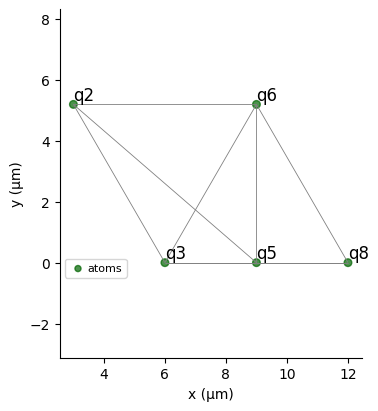

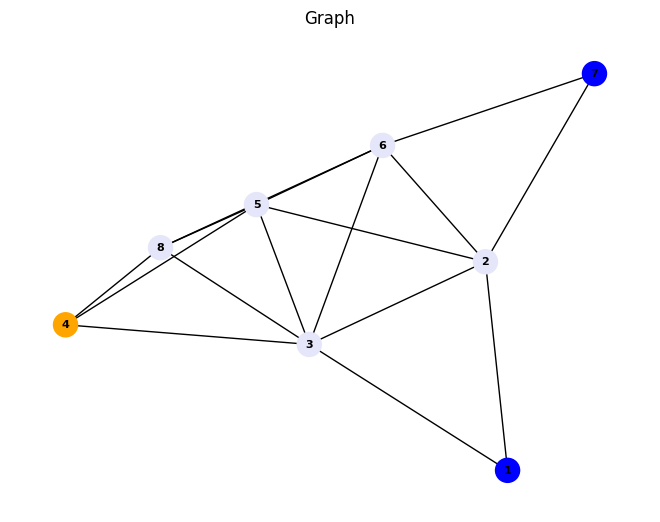

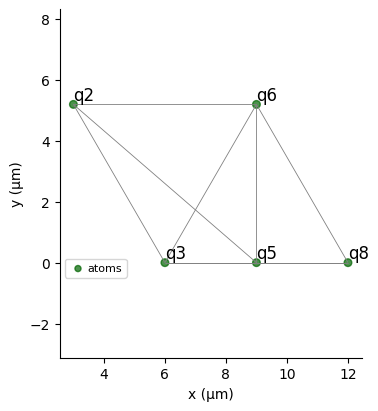

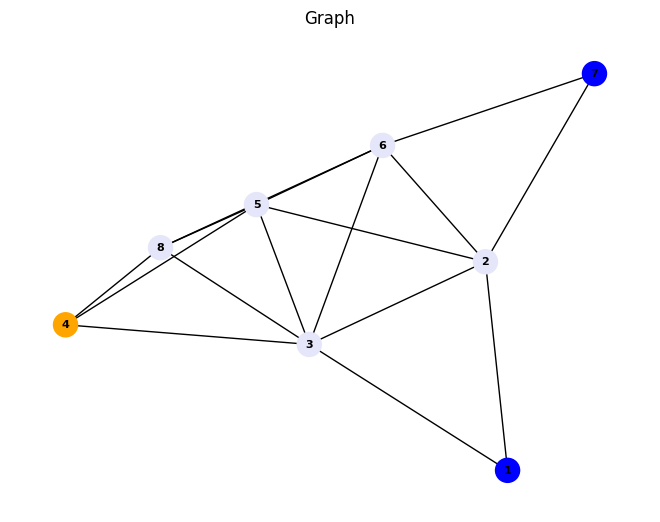

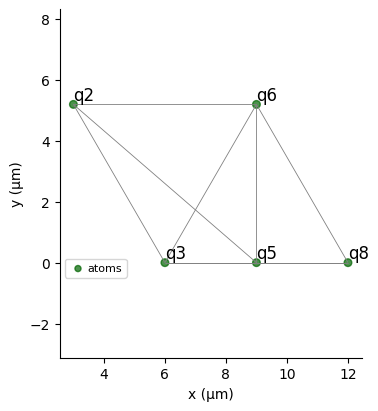

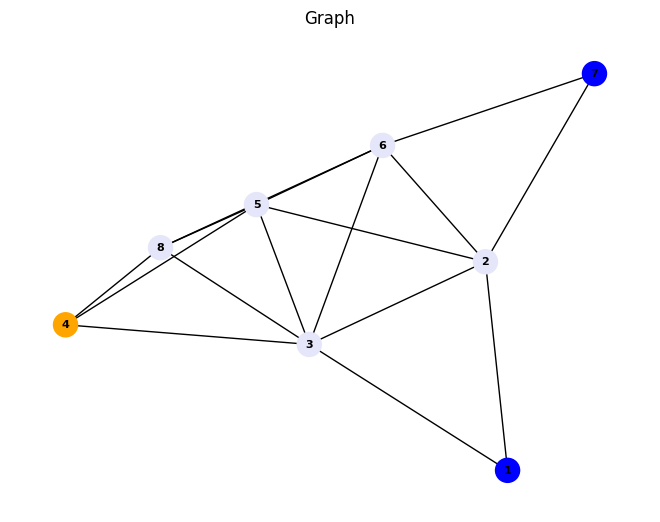

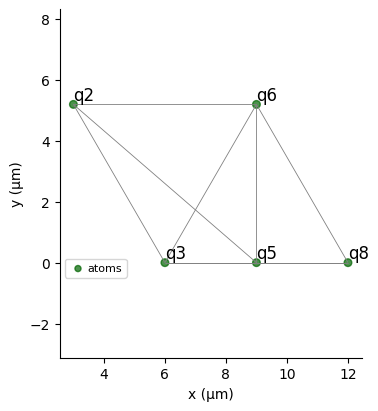

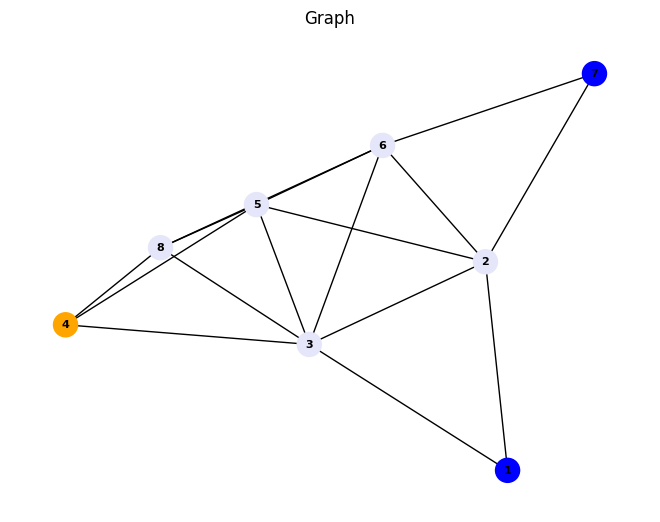

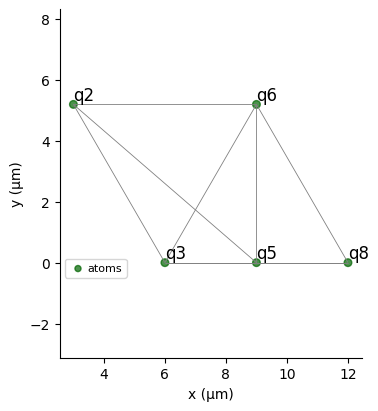

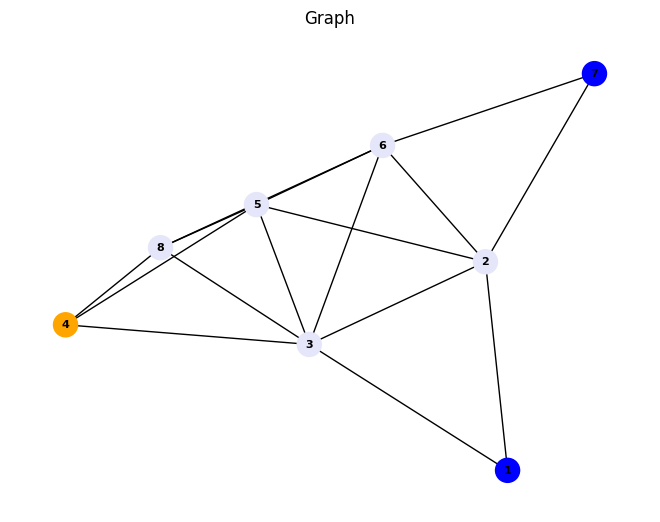

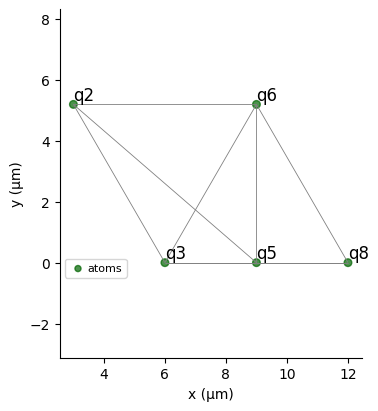

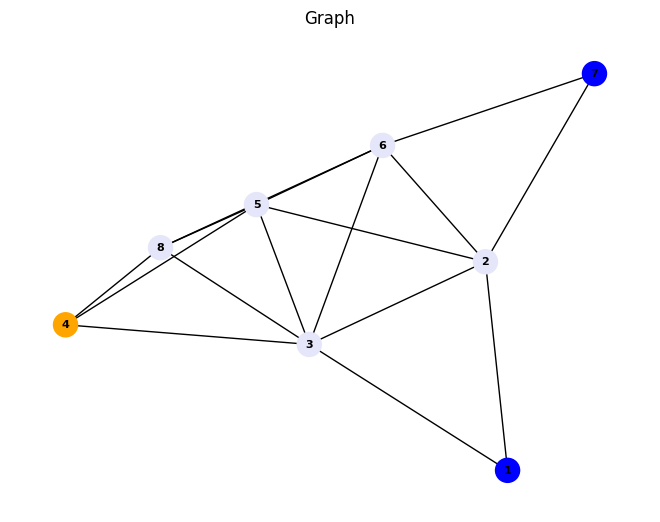

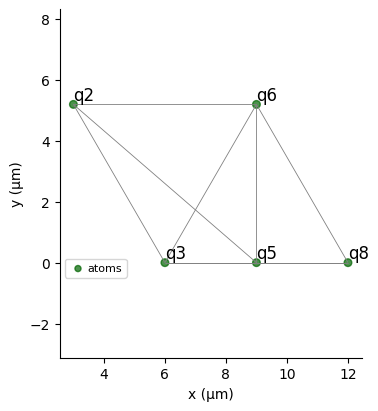

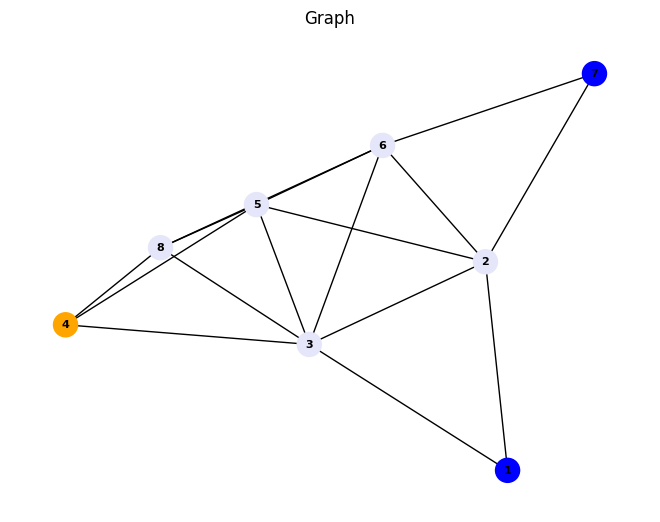

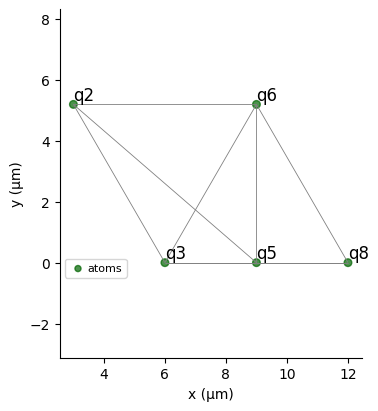

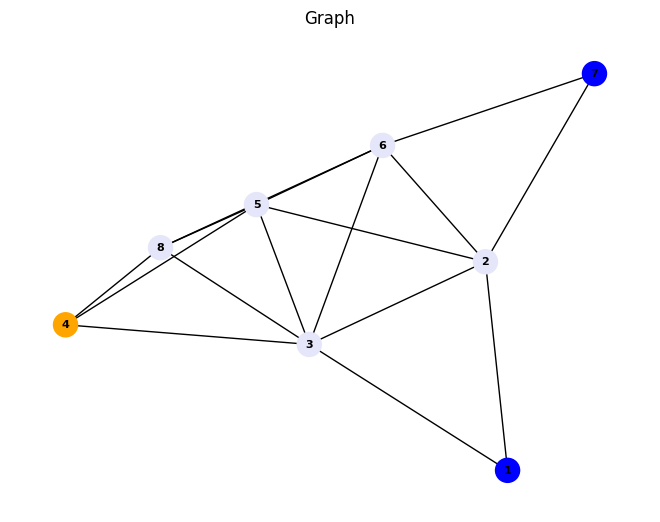

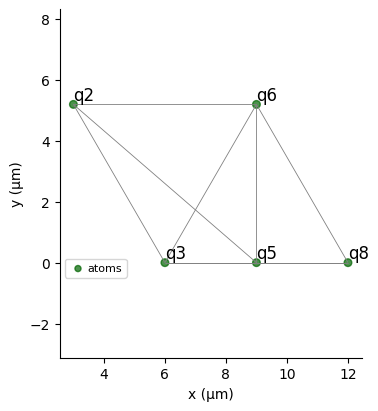

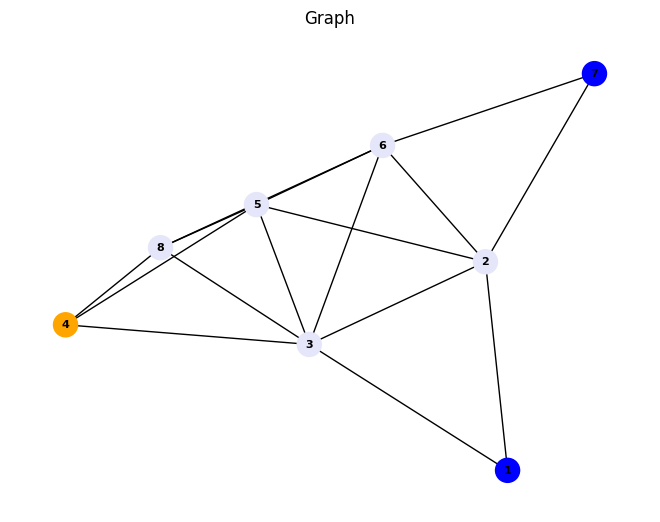

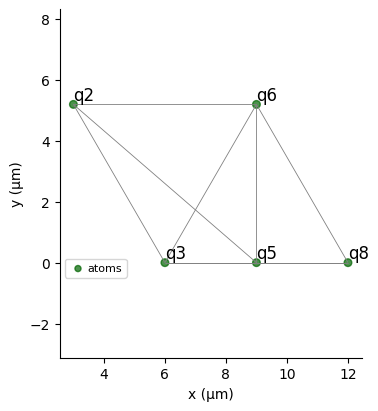

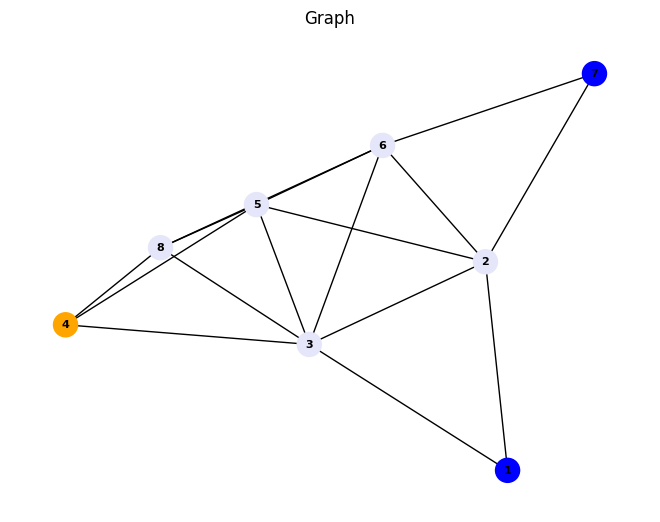

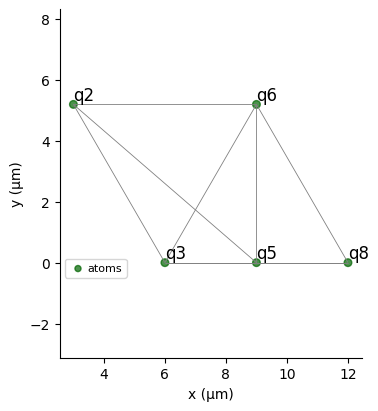

KeyboardInterrupt: 

In [22]:
antenna_coordinates = [(0, 0), (3, 5.2), (6, 0), (9, -5.2), (9, 0), (9, 5.2), (9, 10.4), (12, 0)]
G = neutral_atom_graph_coloring(antenna_coordinates)

### Step 5
Improve the implementation by including realistic error sources and hardware requirements in the algorithm (see 30/10 lecture)

### Step 6
Write a short report detailing the work